In [1]:
import math

# import import_ipynb
# from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

# with the new api
from importnb import imports
with imports("ipynb"):
    from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

TANGARA_4B1A    float64
TANGARA_14D6    float64
TANGARA_2B42    float64
TANGARA_2E9A    float64
TANGARA_2FF6    float64
TANGARA_307A    float64
TANGARA_48C6    float64
TANGARA_F1AE    float64
TANGARA_06BE    float64
TANGARA_260A    float64
dtype: object


,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE,TANGARA_260A
DATETIME,,,,,,,,,,
2023-11-03 00:00:30-05:00,12.0,17.0,24.0,23.0,16.0,13.0,7.0,14.0,22.0,NaN
2023-11-03 00:01:00-05:00,12.0,18.0,24.0,23.0,18.0,16.0,NaN,14.0,26.0,NaN
2023-11-03 00:01:30-05:00,12.0,17.0,24.0,19.0,19.0,16.0,NaN,13.0,25.0,NaN
2023-11-03 00:02:00-05:00,13.0,16.0,25.0,17.0,20.0,16.0,NaN,13.0,23.0,NaN
2023-11-03 00:02:30-05:00,12.0,16.0,24.0,19.0,19.0,15.0,NaN,14.0,23.0,NaN


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE,TANGARA_260A
count,2718.000000,2677.000000,2729.000000,2676.000000,2734.000000,2697.000000,2615.000000,2450.000000,2730.000000,1674.000000
mean,10.569536,8.163990,6.953829,7.423019,6.553036,6.137560,5.584321,7.850612,8.706593,5.550179
std,9.294518,5.041272,7.510945,6.510987,6.794722,4.602926,4.202650,4.690125,7.747243,3.460501
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,5.000000,4.000000,1.000000,2.000000,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000
50%,8.000000,7.000000,4.000000,6.000000,4.000000,5.000000,4.000000,6.000000,5.000000,5.000000
75%,13.000000,13.000000,10.000000,11.000000,12.000000,8.000000,9.000000,12.000000,17.000000,7.000000
max,126.000000,37.000000,31.000000,34.000000,35.000000,27.000000,39.000000,22.000000,43.000000,25.000000


## Missing Data

In [4]:
# Missing Data Threshold
threshold = 90
print(f'Threshold: {threshold}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    is_ok, data_percent, missing_data_percent = to_be_checked(df_pm25_sensor, threshold)
    if not is_ok:
        print(f"Tangara Sensor: {id_tangara_sensor}, Data: {data_percent}%, Missing: {missing_data_percent}%, To be checked")

Threshold: 90%
Tangara Sensor: TANGARA_F1AE, Data: 89%, Missing: 11%, To be checked
Tangara Sensor: TANGARA_260A, Data: 61%, Missing: 39%, To be checked


/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_data_percent = round(df_sensor.isna().sum()[0] * 100 / total)
/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_percent = round(df_sensor.count()[0] * 100 / total)
/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

## Data Correlation

In [5]:
# Data Correlation Threshold
threshold = 0.9
print(f'Threshold: {threshold}%')

ID_REFE_TANGARA_SENSOR='TANGARA_06BE'
ID_TARG_TANGARA_SENSOR='TANGARA_2FF6'
# Reference Tangara Sensor
df_reference_sensor = df_pm25_raw[ID_REFE_TANGARA_SENSOR]
# Target Tangara Sensor
df_target_sensor = df_pm25_raw[ID_TARG_TANGARA_SENSOR]

# To be checked
if not math.isnan(df_reference_sensor.std()):
    is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
    if not is_ok:
        print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {ID_TARG_TANGARA_SENSOR}, Correlation: {corr}, To be checked")

# For each Tangara sensor
# for id_tangara_sensor in df_pm25_raw.columns:
#     # Target Tangara Sensor
#     df_target_sensor = df_pm25_raw[id_tangara_sensor]
#     # To be checked
#     is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
#     if not is_ok:
#         print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {id_tangara_sensor}, Correlation: {corr}, To be checked")

Threshold: 0.9%
Reference Tangara Sensor: TANGARA_06BE, Target Tangara Sensor: TANGARA_2FF6, Correlation: 0.0, To be checked


## Histograms

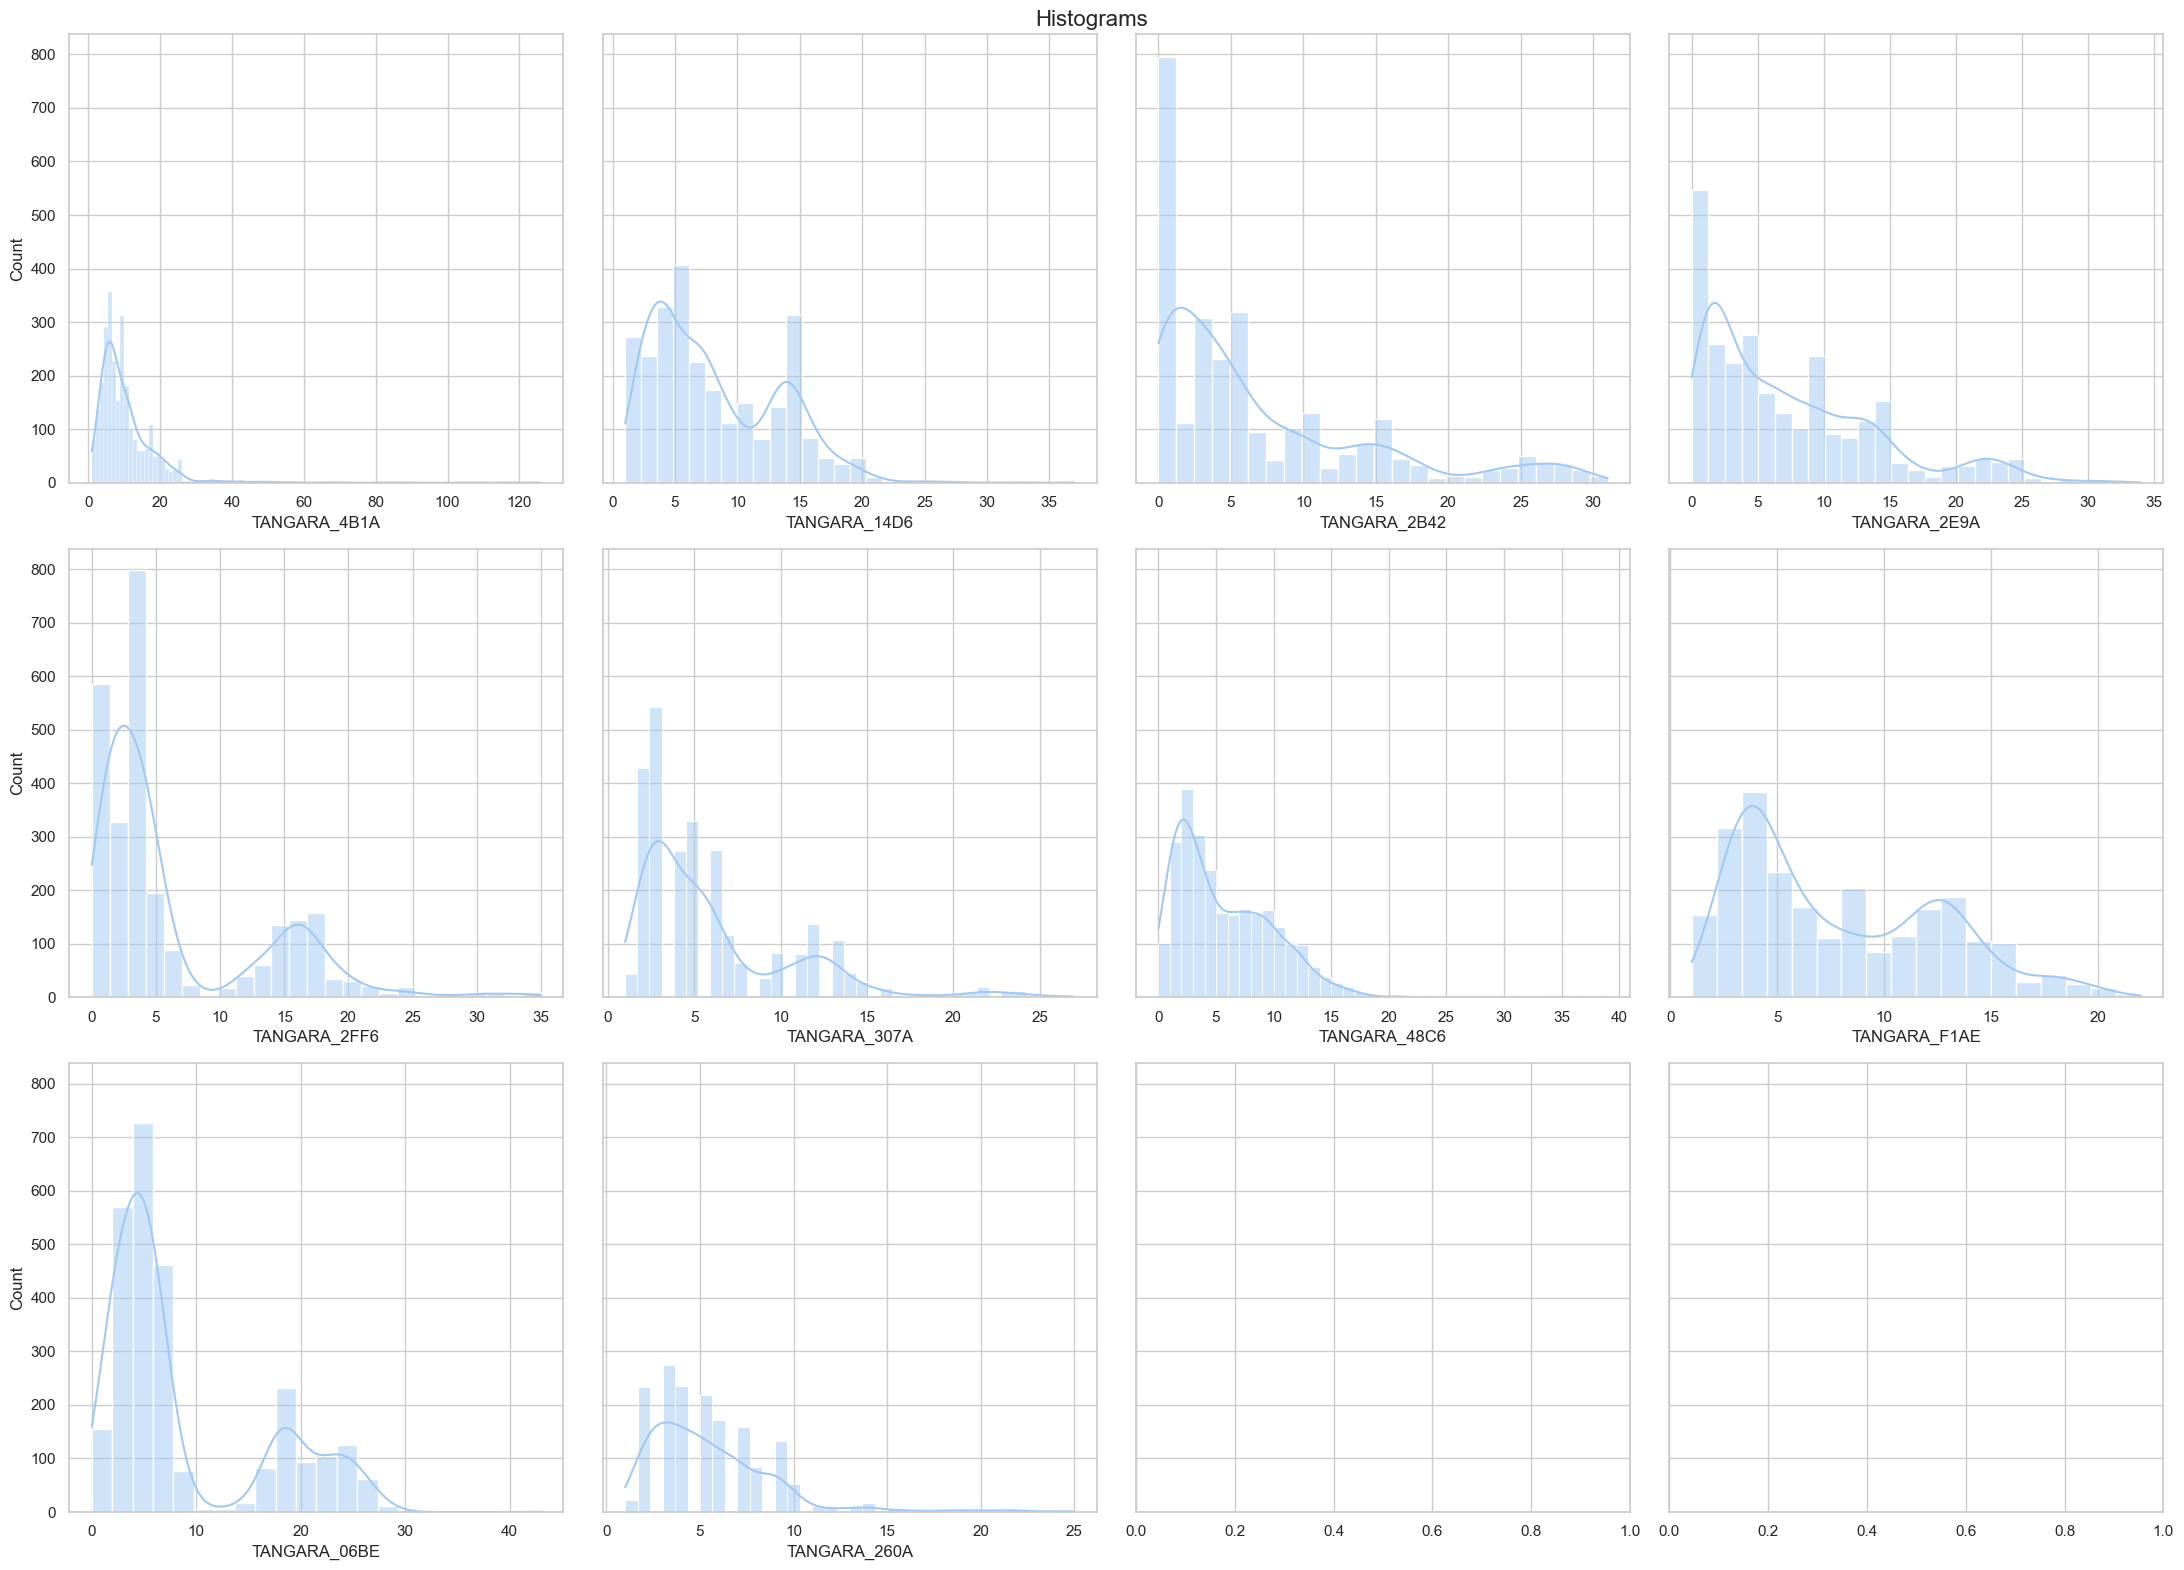

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

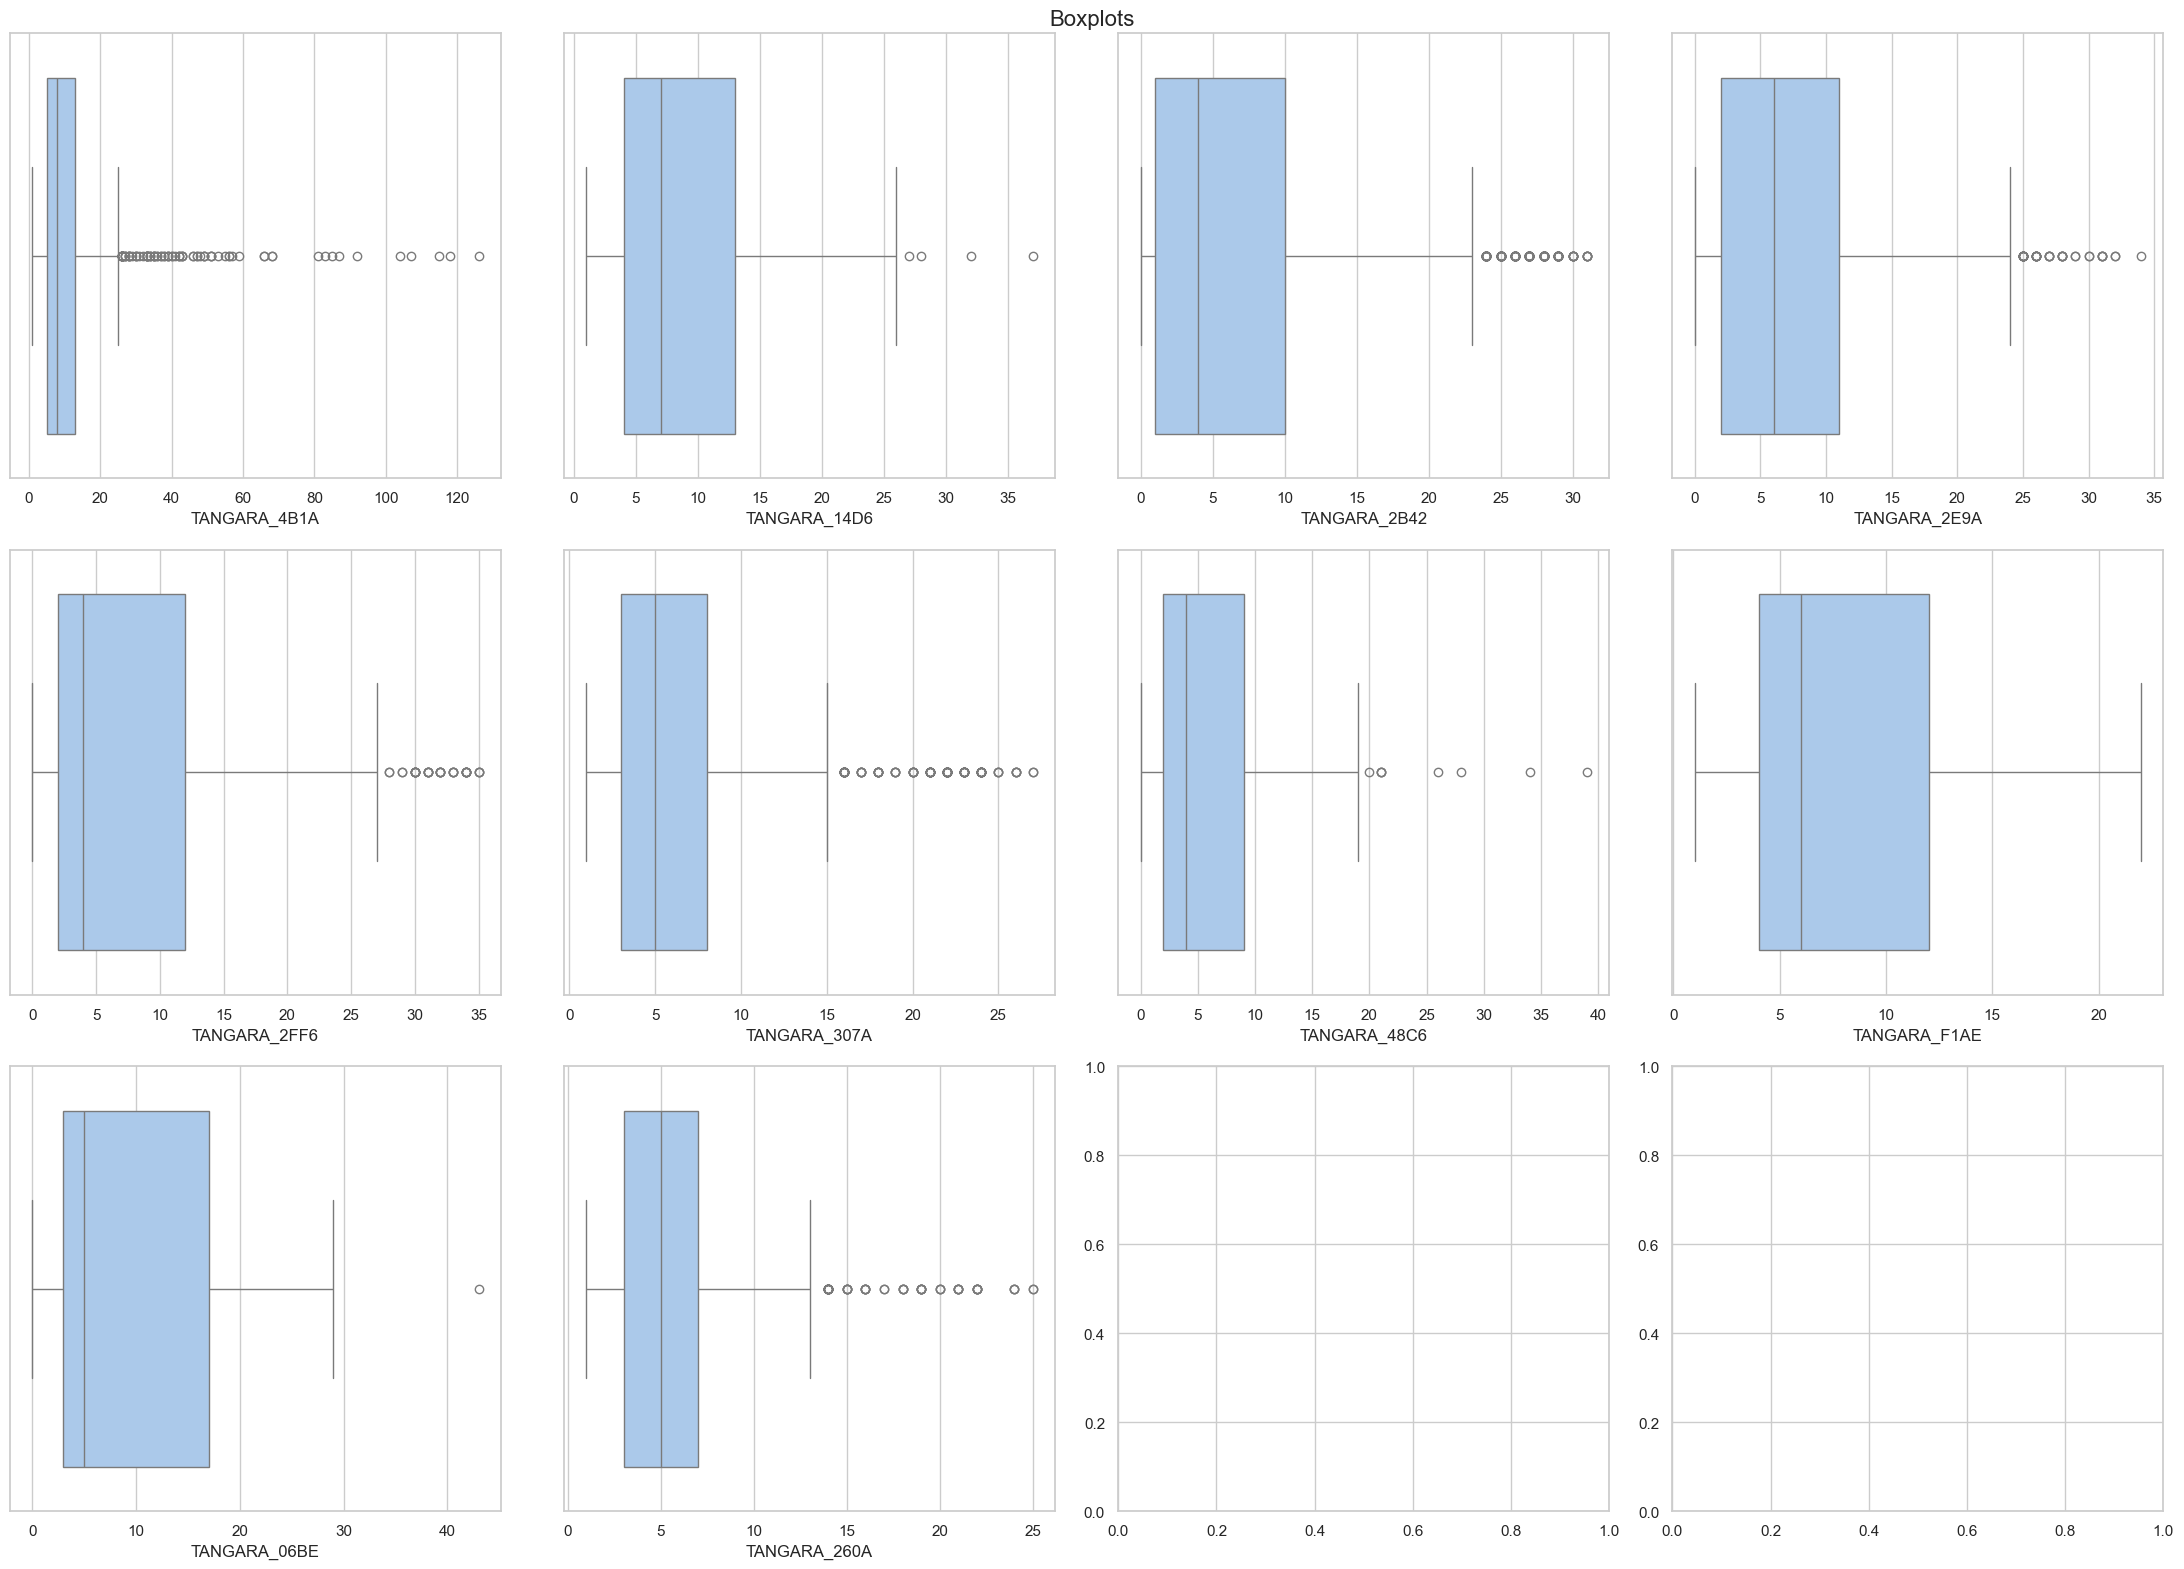

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

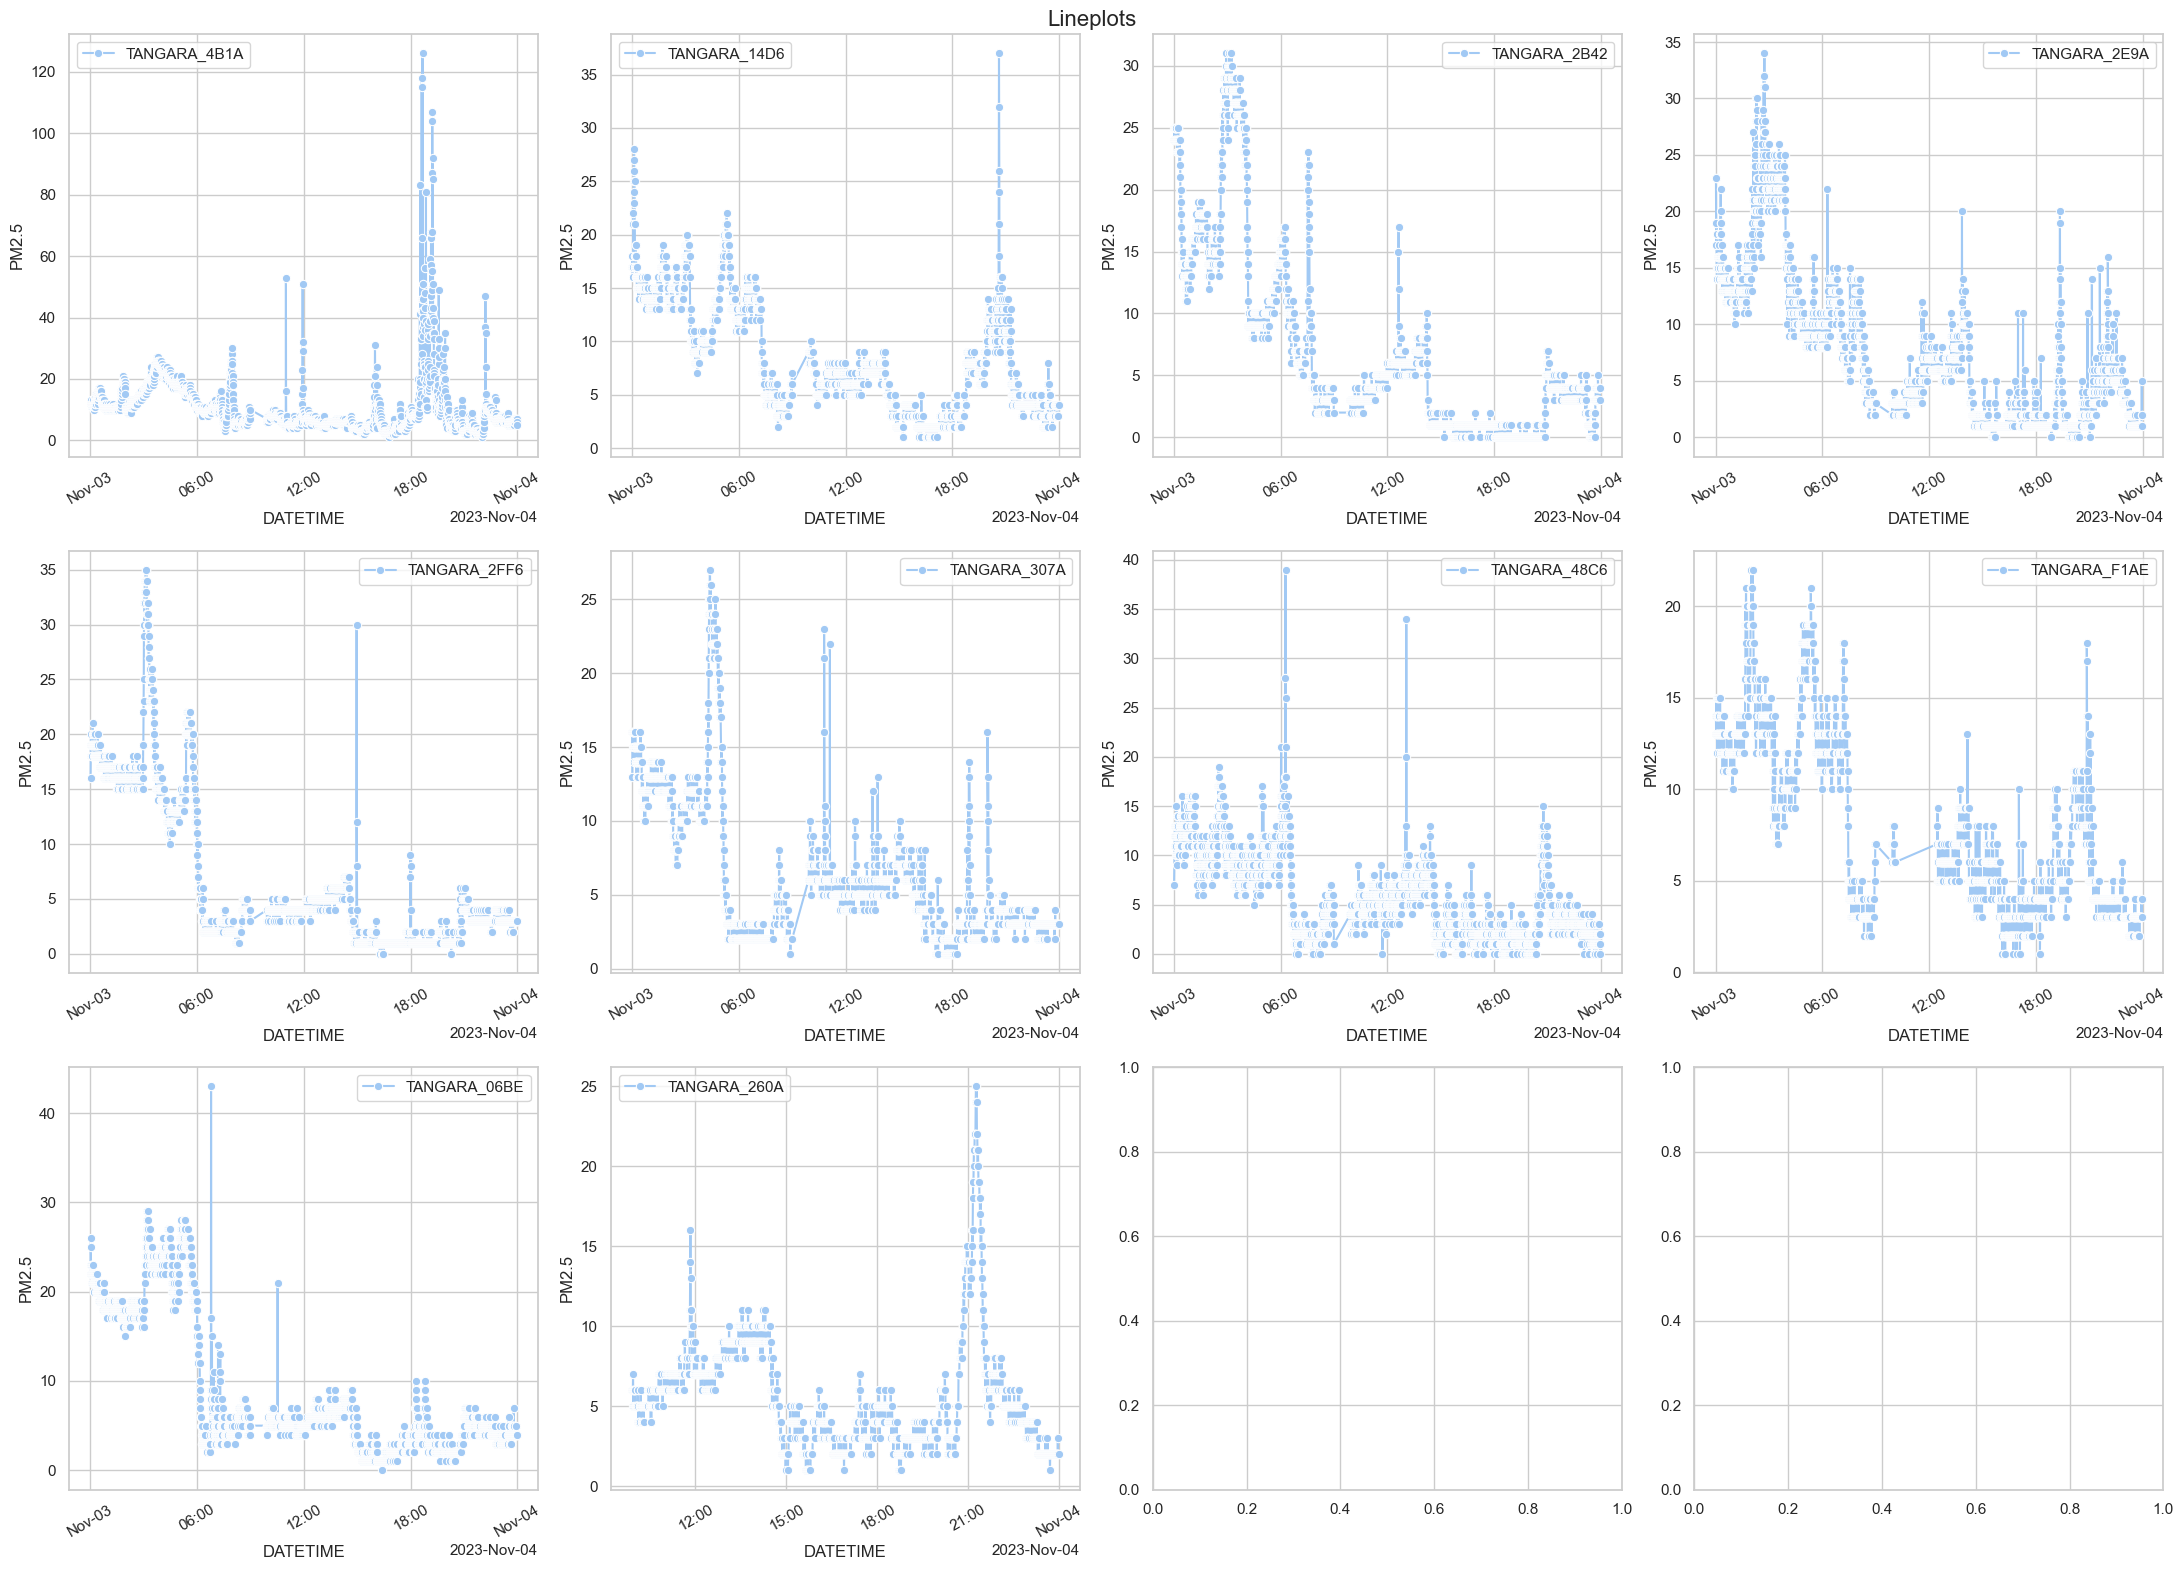

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE,TANGARA_260A
count,2626.000000,2673.000000,2544.000000,2635.000000,2699.000000,2595.000000,2607.000000,2450.000000,2729.000000,1616.000000
mean,9.375476,8.129817,5.510220,7.113093,6.225269,5.560308,5.520905,7.850612,8.694027,5.110767
std,5.417284,4.964619,5.432304,6.056940,6.190305,3.581699,4.033371,4.690125,7.720785,2.528742
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,5.000000,4.000000,1.000000,2.000000,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000
50%,8.000000,7.000000,4.000000,6.000000,4.000000,5.000000,4.000000,6.000000,5.000000,5.000000
75%,12.000000,13.000000,9.000000,11.000000,10.000000,7.000000,8.500000,12.000000,17.000000,7.000000
max,25.000000,26.000000,23.000000,24.000000,27.000000,15.000000,19.000000,22.000000,29.000000,13.000000


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_4B1A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE,TANGARA_260A
count,2626.000000,2673.000000,2544.000000,2635.000000,2699.000000,2595.000000,2607.000000,2450.000000,2729.000000,1616.000000
mean,9.375476,8.129817,5.510220,7.113093,6.225269,5.560308,5.520905,7.850612,8.694027,5.110767
std,5.417284,4.964619,5.432304,6.056940,6.190305,3.581699,4.033371,4.690125,7.720785,2.528742
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,5.000000,4.000000,1.000000,2.000000,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000
50%,8.000000,7.000000,4.000000,6.000000,4.000000,5.000000,4.000000,6.000000,5.000000,5.000000
75%,12.000000,13.000000,9.000000,11.000000,10.000000,7.000000,8.500000,12.000000,17.000000,7.000000
max,25.000000,26.000000,23.000000,24.000000,27.000000,15.000000,19.000000,22.000000,29.000000,13.000000


## Histograms

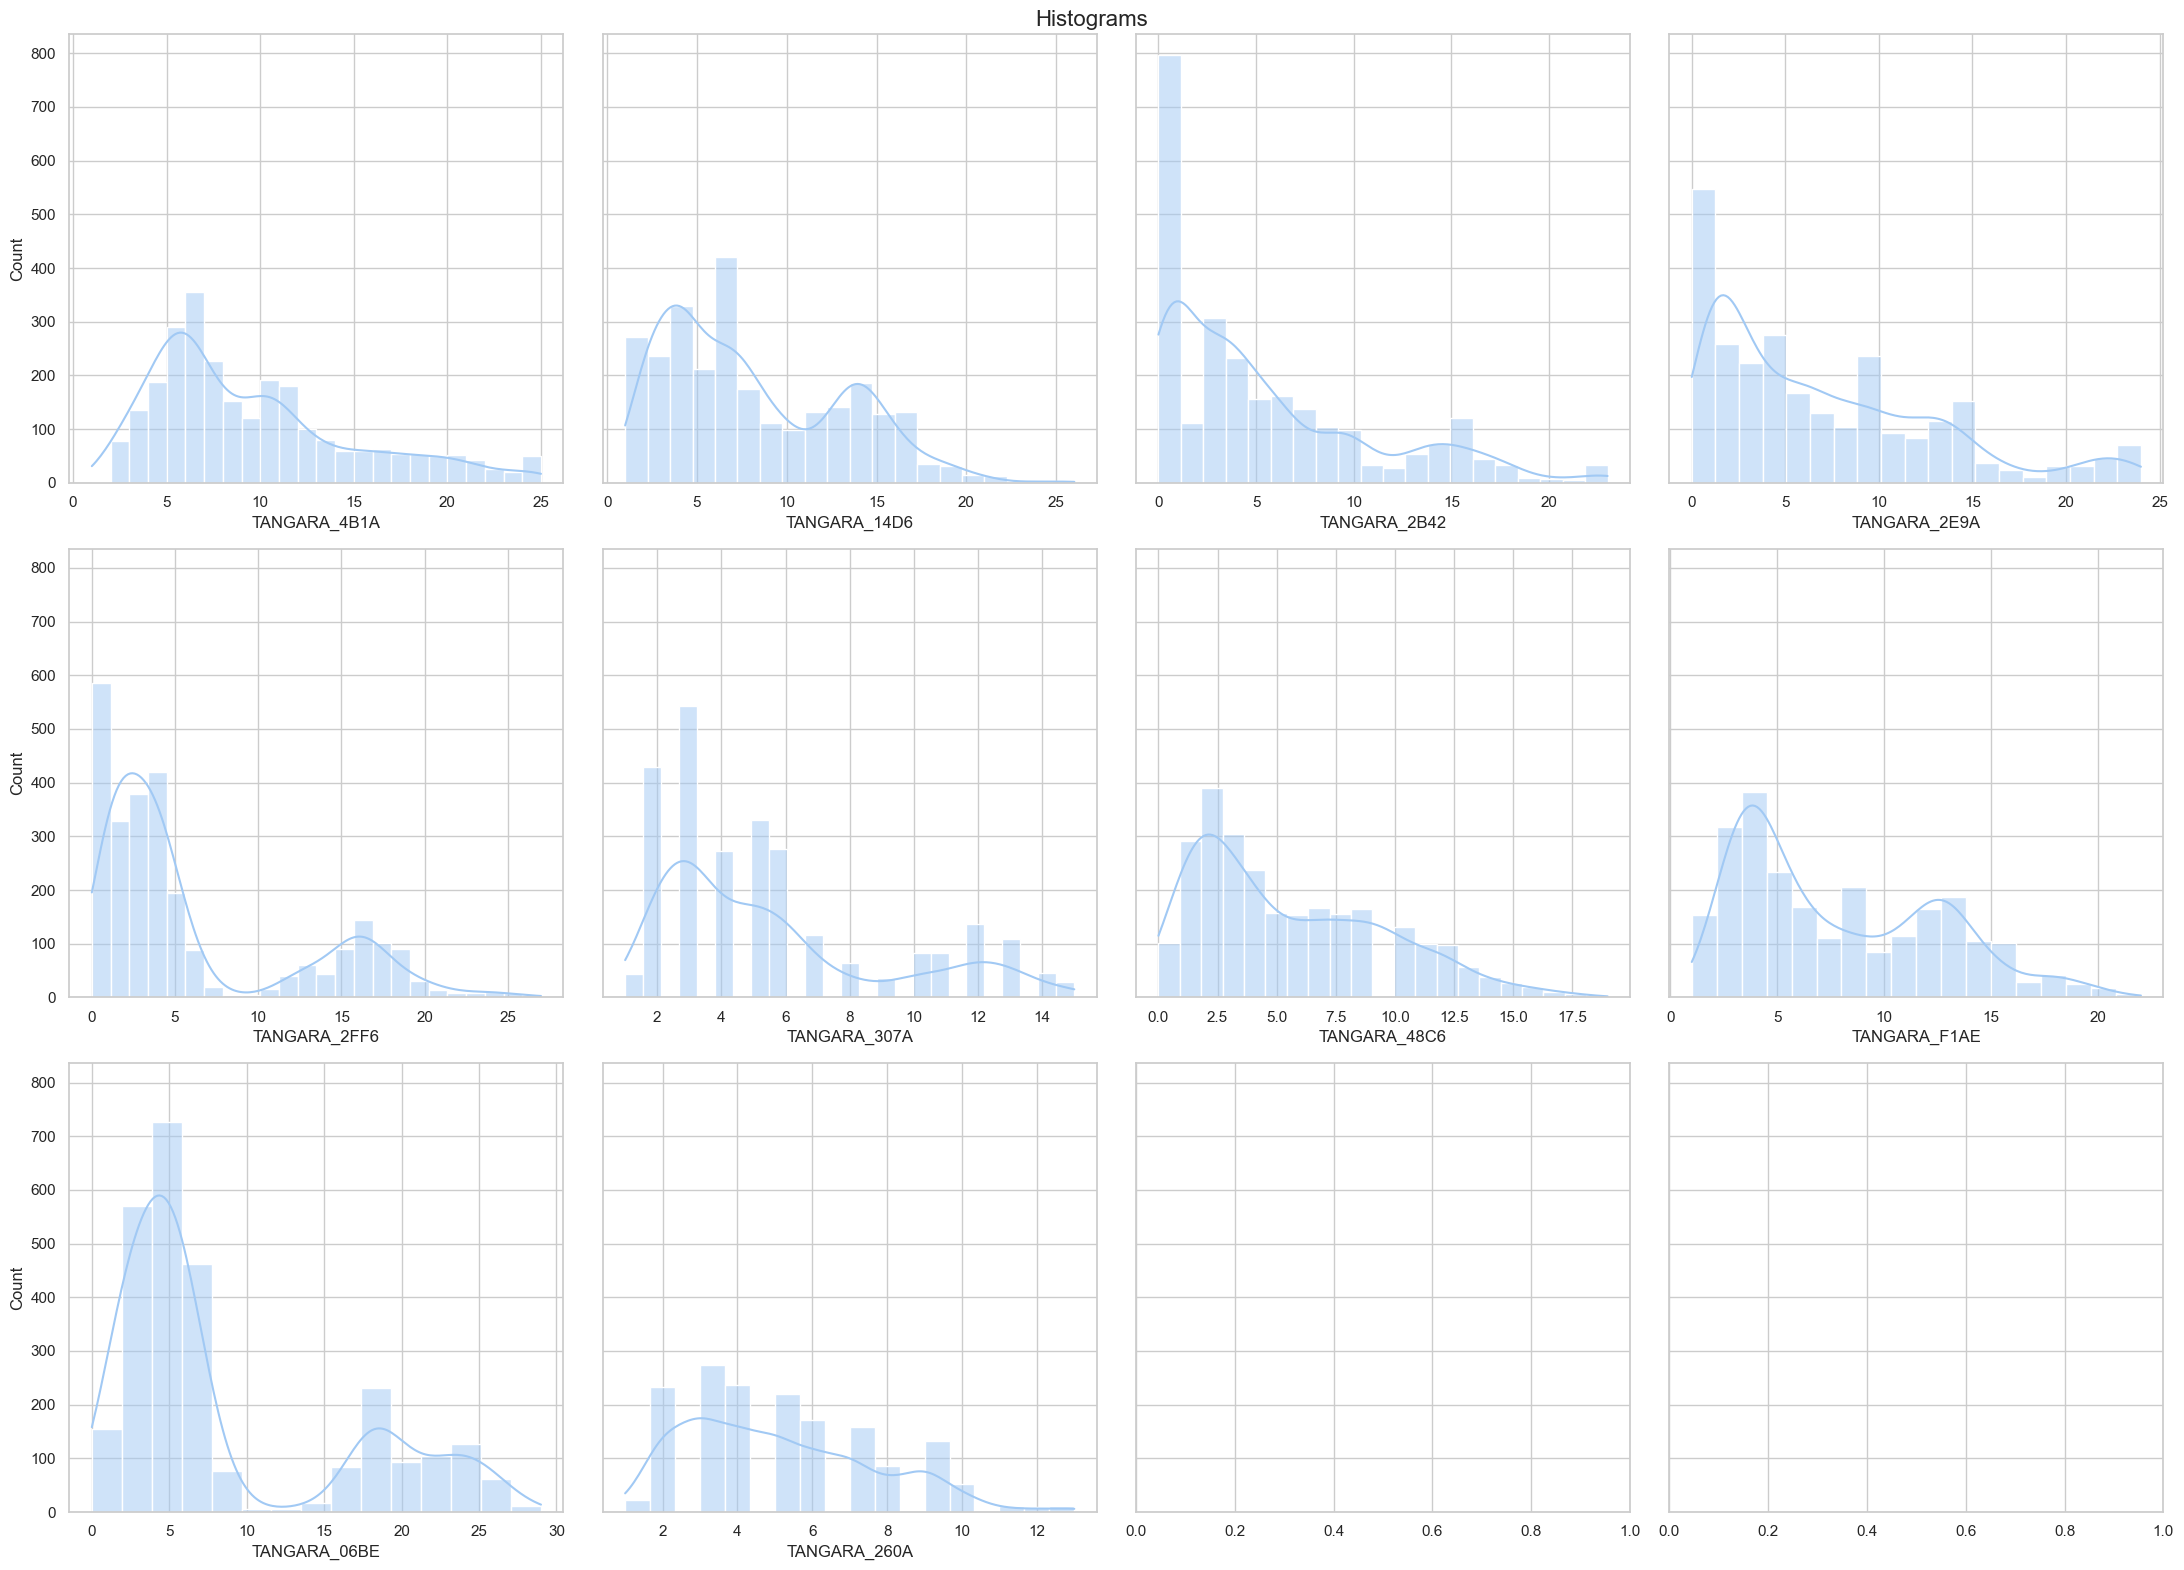

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

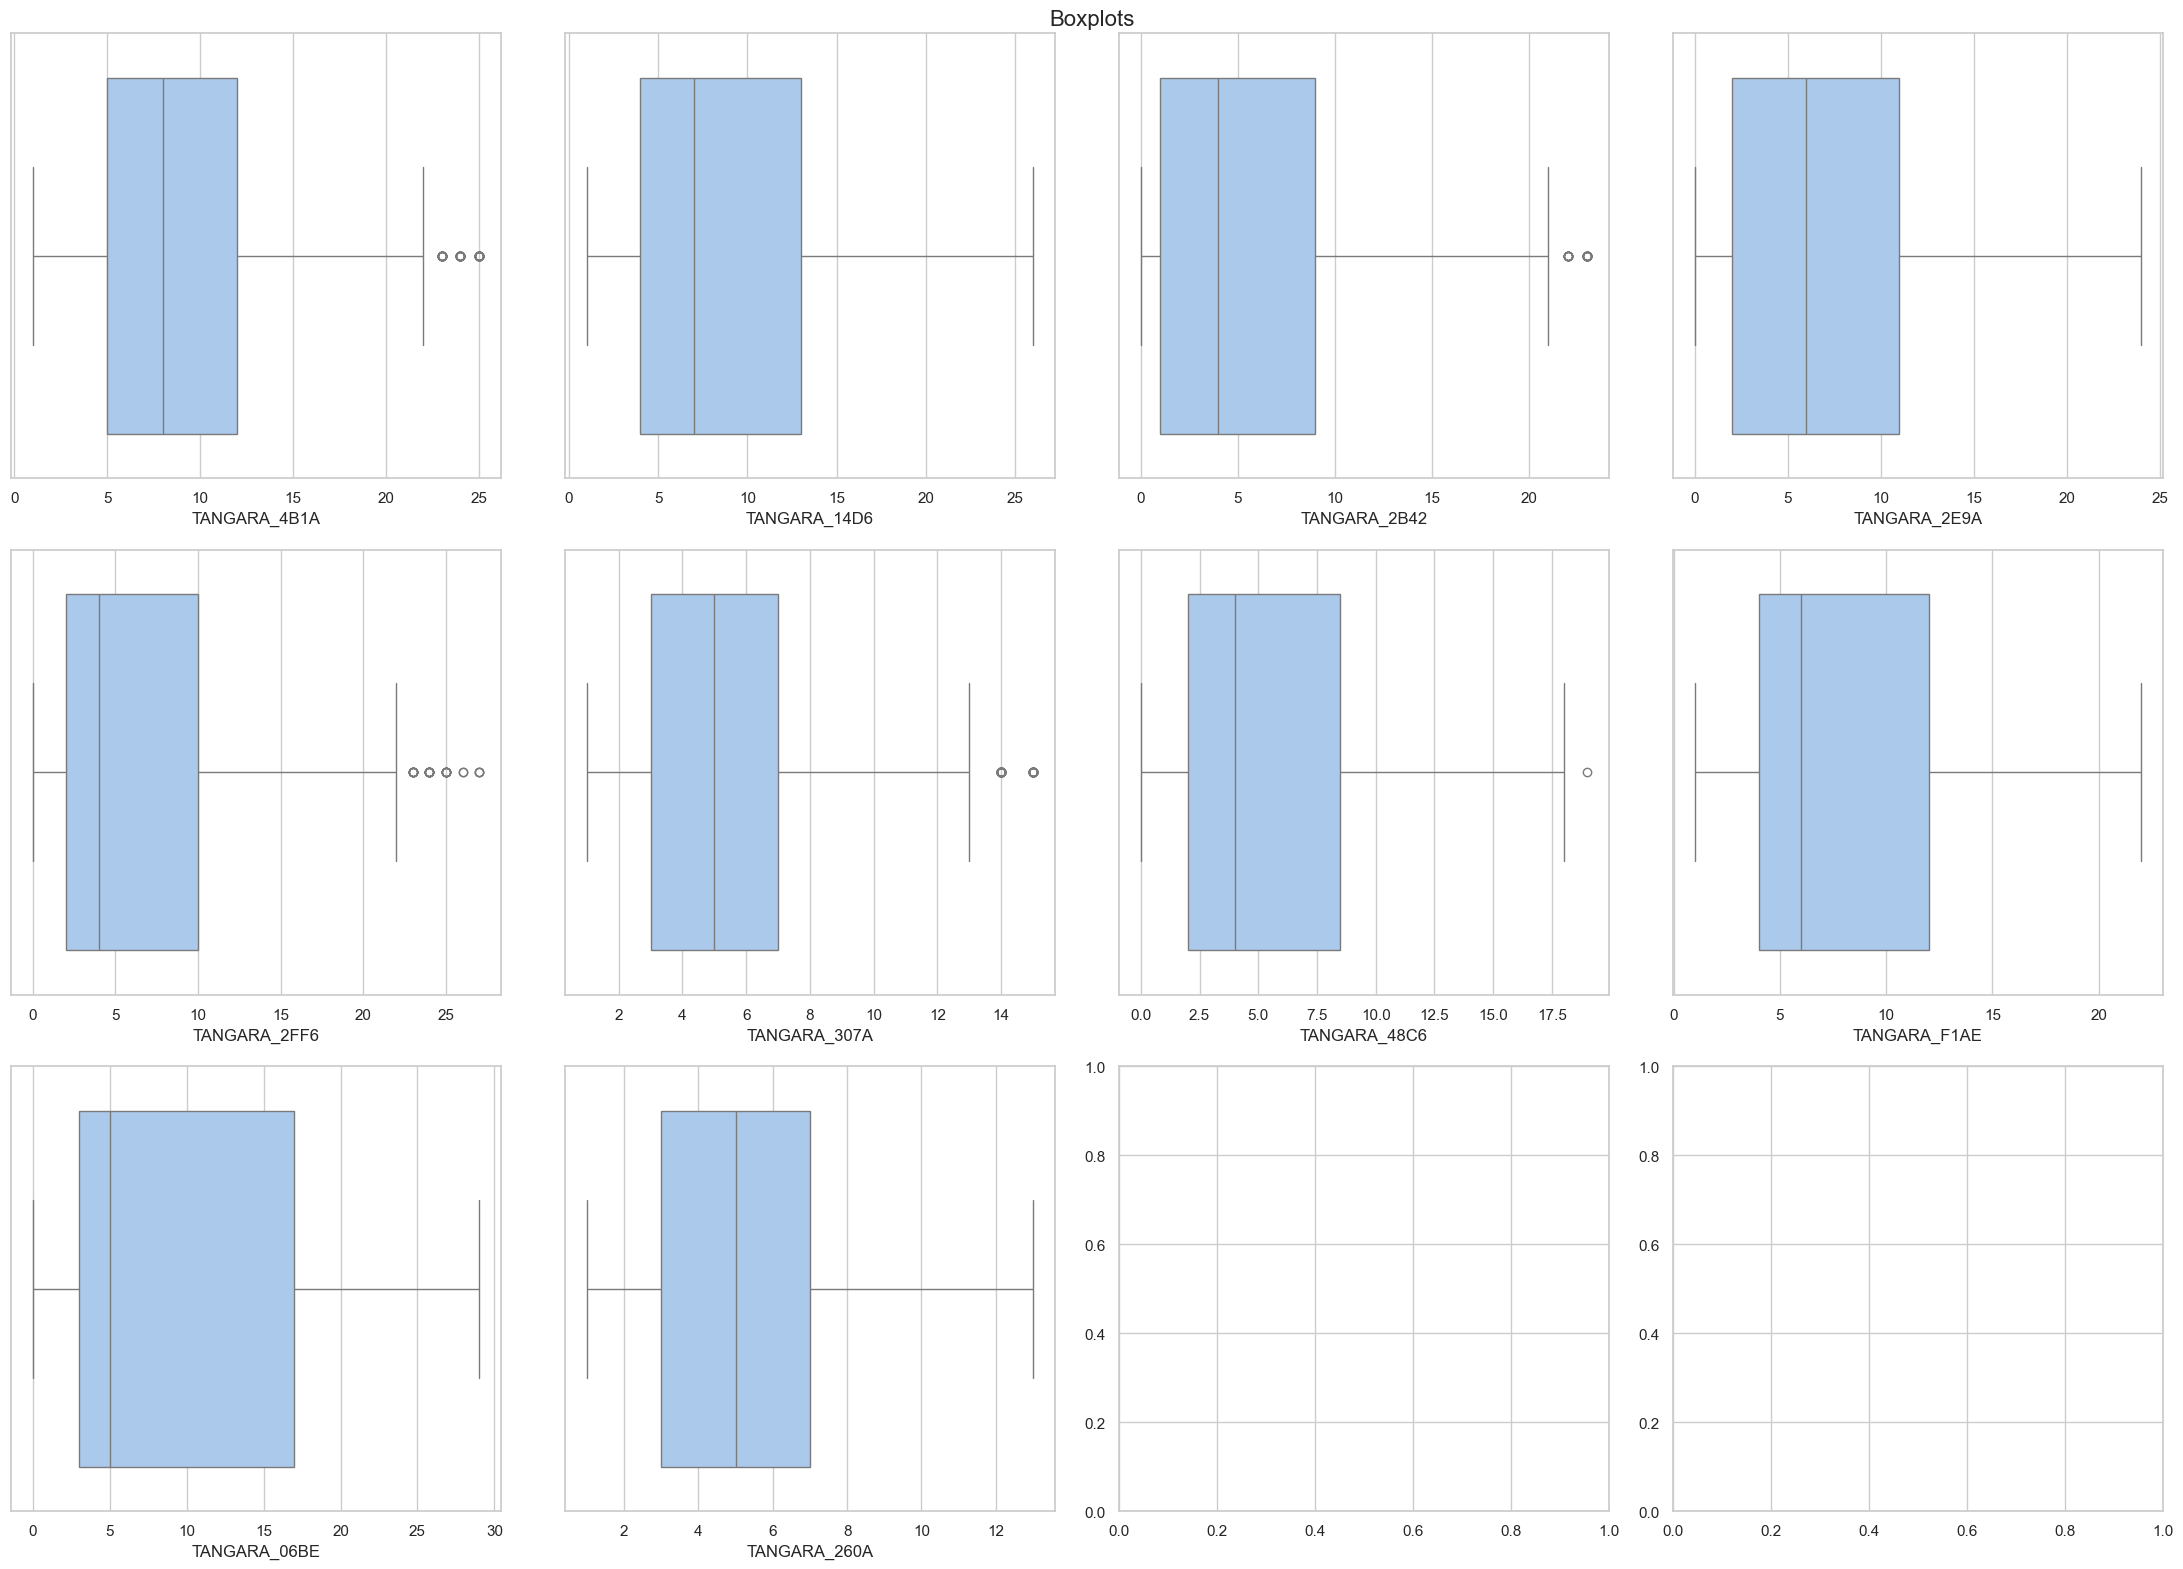

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

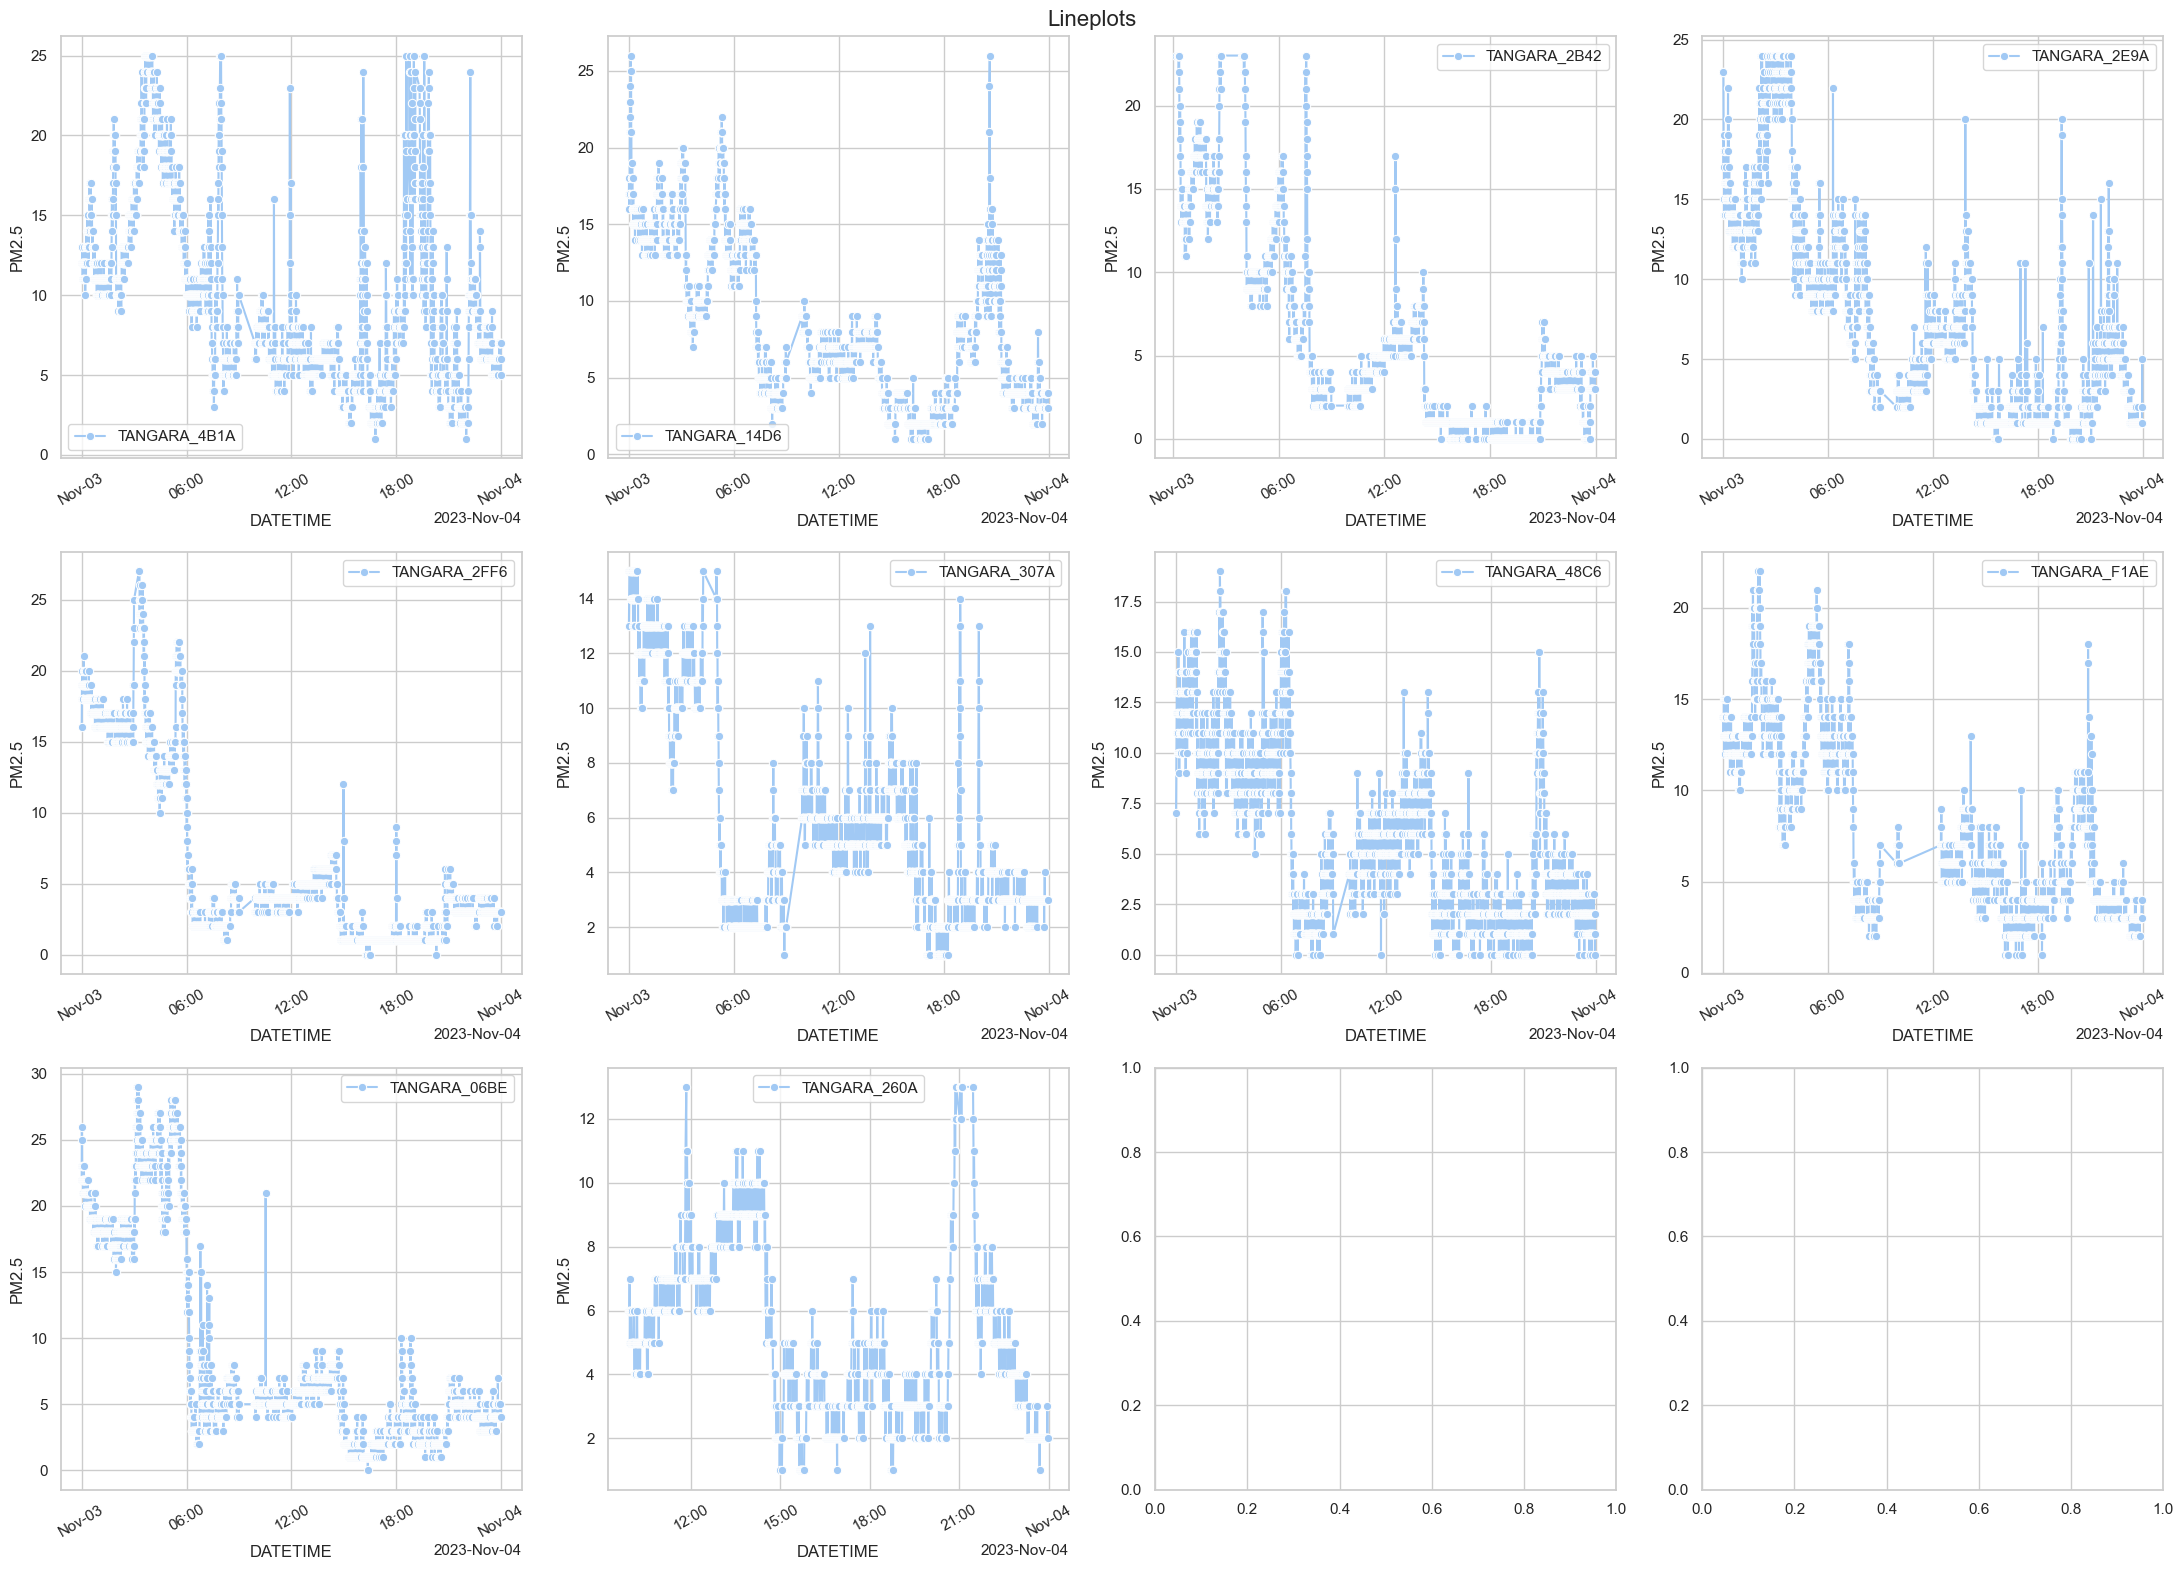

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')